## Section 1: Setup & Configuration

In [1]:
# ============================================================================
# DEPENDENCIES INSTALLATION
# ============================================================================

!pip install jax jaxlib optax flax pandas numpy matplotlib seaborn scikit-learn optuna -q

print("✓ All dependencies installed")

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


✓ All dependencies installed


✓ All dependencies installed
JAX version: 0.5.2
Available devices: [CpuDevice(id=0)]
Default backend: cpu

✓ Using TRULY RANDOM seed: 461855884
  (Seed generated from current time, not fixed)

✓ Configuration loaded
  Model types: ['JAX_SimpleNN', 'JAX_DNN']
  Training modes: ['WithoutOptuna', 'WithOptuna']
  Momentum ranges: 2
  Save directory: /kaggle/working/trained_models
  Input directory: /kaggle/input/jax-models

✓ Section 1 COMPLETE

Total models to train: 2 models × 2 ranges × 2 modes = 8 models


## Section 2: Data Loading & Preprocessing

In [3]:
# ============================================================================
# LOAD DATA (Once for both analyses)
# ============================================================================

CSV_PATH = '/kaggle/input/pid-features/pid_features_large.csv'

print("\nLoading data (shared for all model analyses)...")
df_iter = pd.read_csv(CSV_PATH, dtype='float32', chunksize=500_000, low_memory=False)
df = pd.concat(df_iter, ignore_index=True)
print(f"✓ Loaded: {df.shape}")

# ============================================================================
# FUNCTION: Preprocess Data for Any Momentum Range
# ============================================================================

def preprocess_momentum_range(df, momentum_range):
    """
    Preprocess data for a specific momentum range
    Returns: X_train, X_test, y_train, y_test, scaler, available_features
    """
    print(f"\n{'='*80}")
    print(f"Processing: {momentum_range['name']}")
    print(f"{'='*80}")
    
    # Filter momentum range
    print(f"\nFiltering momentum range: {momentum_range['name']}")
    df_range = df[(df['pt'] >= momentum_range['min']) & 
                  (df['pt'] < momentum_range['max'])].copy()
    print(f"✓ Selected {len(df_range):,} tracks in range")
    
    # Handle missing values
    df_range.replace(-999, np.nan, inplace=True)
    
    tof_features = [col for col in df_range.columns if 'tof' in col.lower()]
    tpc_features = [col for col in df_range.columns if 'tpc' in col.lower()]
    bayes_features = [col for col in df_range.columns if 'bayes_prob' in col.lower()]
    
    # Fill missing values
    df_range[tof_features] = df_range[tof_features].fillna(0)
    df_range[tpc_features] = df_range[tpc_features].fillna(0)
    df_range[bayes_features] = df_range[bayes_features].fillna(0)
    
    # Create indicator features
    df_range['has_tof'] = (df_range[tof_features].abs().sum(axis=1) > 0).astype(int)
    df_range['has_tpc'] = (df_range[tpc_features].abs().sum(axis=1) > 0).astype(int)
    
    # Map PDG codes
    def pdg_to_species(pdg):
        ap = abs(int(pdg))
        if ap == 211:
            return 0
        elif ap == 321:
            return 1
        elif ap == 2212:
            return 2
        elif ap == 11:
            return 3
        else:
            return -1
    
    df_range['particle_species'] = df_range['mc_pdg'].apply(pdg_to_species)
    df_range = df_range[df_range['particle_species'] >= 0].reset_index(drop=True)
    
    print(f"✓ Valid particles: {len(df_range):,}")
    
    # ===== BACKGROUND CLEANING =====
    initial_count = len(df_range)
    
    # Momentum cuts
    df_range = df_range[(df_range['pt'] > 0.05) & 
                        (df_range['pt'] < 20)].copy()
    
    # DCA cuts
    dca_cut = 3.0
    df_range = df_range[(df_range['dca_xy'].abs() < dca_cut) & 
                        (df_range['dca_z'].abs() < dca_cut)].copy()
    
    # PID consistency
    nsigma_threshold = 5.0
    for particle in ['pi', 'ka', 'pr', 'el']:
        tpc_col = f'tpc_nsigma_{particle}'
        tof_col = f'tof_nsigma_{particle}'
        if tpc_col in df_range.columns and tof_col in df_range.columns:
            df_range = df_range[
                ~((df_range[tpc_col].abs() > nsigma_threshold) & 
                  (df_range[tof_col].abs() > nsigma_threshold))
            ].copy()
    
    print(f"\n✓ Background cleaning: {initial_count - len(df_range):,} tracks removed")
    print(f"  Clean dataset: {len(df_range):,} tracks ({len(df_range)/initial_count*100:.1f}% retained)")
    
    # Class distribution
    print(f"\nClass distribution:")
    class_counts = df_range['particle_species'].value_counts().sort_index()
    for idx, count in class_counts.items():
        print(f"  {PARTICLE_NAMES[idx]:10s}: {count:7,} ({count/len(df_range)*100:5.2f}%)")
    
    # ===== FEATURE SELECTION & SCALING =====
    training_features = [
        'pt', 'eta', 'phi', 'tpc_signal',
        'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
        'tof_beta',
        'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
        'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
        'dca_xy', 'dca_z',
        'has_tpc', 'has_tof'
    ]
    
    available_features = [f for f in training_features if f in df_range.columns]
    df_range = df_range.dropna(subset=available_features)
    
    X = df_range[available_features].astype('float32')
    y = df_range['particle_species'].values.astype('int32')
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y
    )
    
    print(f"\n✓ Train samples: {len(X_train):,}")
    print(f"✓ Test samples: {len(X_test):,}")
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.values)
    X_test_scaled = scaler.transform(X_test.values)
    
    # Diagnostics
    print(f"\nFeature scaling diagnostics:")
    print(f"  Mean: {X_train_scaled.mean():.6f} (expect ~0)")
    print(f"  Std:  {X_train_scaled.std():.6f} (expect ~1)")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, available_features

print("\n✓ Data preprocessing function defined")


Loading data (shared for all model analyses)...
✓ Loaded: (4729393, 37)

✓ Data preprocessing function defined


## Section 3: Training Function (Reusable)

In [4]:
# ============================================================================
# MODEL 1: JAX SIMPLE NEURAL NETWORK
# ============================================================================

class JAX_SimpleNN(nn.Module):
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        z = x
        for i, dim in enumerate(self.hidden_dims):
            z = nn.Dense(dim, name=f'dense_{i}')(z)
            z = nn.relu(z)
            z = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(z)
        logits = nn.Dense(self.num_classes, name='output')(z)
        return logits

print("✓ JAX_SimpleNN model defined")

# ============================================================================
# MODEL 2: JAX DEEP NEURAL NETWORK
# ============================================================================

class JAX_DNN(nn.Module):
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        z = x
        for i, dim in enumerate(self.hidden_dims):
            z = nn.Dense(dim, name=f'dense_{i}')(z)
            z = nn.relu(z)
            z = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(z)
        logits = nn.Dense(self.num_classes, name='output')(z)
        return logits

print("✓ JAX_DNN model defined")

# ============================================================================
# LOSS FUNCTION & TRAINING FUNCTIONS
# ============================================================================

def weighted_cross_entropy_loss(logits, labels, class_weights):
    """Weighted cross-entropy loss for imbalanced classes"""
    one_hot_labels = jax.nn.one_hot(labels, NUM_CLASSES)
    log_softmax = jax.nn.log_softmax(logits, axis=-1)
    sample_weights = class_weights[labels]
    loss = -jnp.sum(one_hot_labels * log_softmax, axis=-1)
    weighted_loss = loss * sample_weights
    return jnp.mean(weighted_loss)

@jit
def train_step(state, batch_x, batch_y, dropout_key, class_weights):
    """Single training step with dropout"""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_x, training=True, 
                               rngs={'dropout': dropout_key})
        loss = weighted_cross_entropy_loss(logits, batch_y, class_weights)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jit
def eval_step(state, batch_x, batch_y):
    """Evaluation step (no dropout)"""
    logits = state.apply_fn({'params': state.params}, batch_x, training=False)
    predictions = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(predictions == batch_y)
    return accuracy, logits

print("✓ Training functions defined")

# ============================================================================
# OPTUNA OBJECTIVE FOR JAX MODELS
# ============================================================================

def create_optuna_objective_jax(model_class, X_train, X_test, y_train, y_test, 
                               model_name='JAX', n_trials=5):
    """Create Optuna objective function for JAX models"""
    
    def objective(trial):
        # Suggest hyperparameters
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.6)
        num_layers = trial.suggest_int('num_layers', 2, 5)
        layer_dim = trial.suggest_int('layer_dim', 64, 512, step=64)
        
        hidden_dims = [layer_dim // (2**i) for i in range(num_layers)]
        
        print(f"\n  Trial {trial.number}: LR={learning_rate:.5f}, "
              f"Dropout={dropout_rate:.2f}, Layers={num_layers}, Dim={layer_dim}")
        
        # Convert to JAX
        X_train_jax = jnp.array(X_train, dtype=jnp.float32)
        X_test_jax = jnp.array(X_test, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.int32)
        y_test_jax = jnp.array(y_test, dtype=jnp.int32)
        
        # Class weights
        class_weights = compute_class_weight('balanced', 
                                            classes=np.unique(y_train), 
                                            y=y_train)
        class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), 
                                     dtype=jnp.float32)
        
        # Initialise model
        key = random.PRNGKey(RANDOM_SEED + trial.number)
        model = model_class(hidden_dims=hidden_dims, 
                          num_classes=NUM_CLASSES, 
                          dropout_rate=dropout_rate)
        
        dummy_input = jnp.ones((1, X_train_jax.shape[1]))
        params = model.init(key, dummy_input, training=False)
        
        # Training state
        tx = optax.adam(learning_rate)
        state = train_state.TrainState.create(
            apply_fn=model.apply, 
            params=params['params'], 
            tx=tx
        )
        
        # Quick training (30 epochs for Optuna)
        best_val_acc = 0.0
        for epoch in range(30):
            main_key, shuffle_key, dropout_key = random.split(key, 3)
            perm = random.permutation(shuffle_key, len(X_train_jax))
            X_train_shuffled = X_train_jax[perm]
            y_train_shuffled = y_train_jax[perm]
            
            # Train batches
            for batch_idx in range(len(X_train_jax) // 256):
                dropout_key, subkey = random.split(dropout_key)
                start_idx = batch_idx * 256
                end_idx = start_idx + 256
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]
                state, _ = train_step(state, batch_x, batch_y, subkey, class_weights_jax)
            
            # Validation
            val_acc, _ = eval_step(state, X_test_jax, y_test_jax)
            best_val_acc = max(best_val_acc, val_acc)
        
        return float(best_val_acc)
    
    # Run Optuna study
    print(f"\n{'='*80}")
    print(f"OPTUNA OPTIMISATION: {model_name}")
    print(f"{'='*80}")
    print(f"Running {n_trials} trials...")
    
    sampler = TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    best_trial = study.best_trial
    print(f"\n✓ Best trial: #{best_trial.number}")
    print(f"  Best accuracy: {best_trial.value:.4f}")
    print(f"  Best params: {best_trial.params}")
    
    return best_trial.params, best_trial.value

print("✓ Optuna objective defined")

# ============================================================================
# SECTION 3 COMPLETE
# ============================================================================

print("\n✓ Section 3 COMPLETE")
print(f"  Models defined: {MODEL_TYPES}")
print(f"  Ready for training!")


✓ JAX_SimpleNN model defined
✓ JAX_DNN model defined
✓ Training functions defined
✓ Optuna objective defined

✓ Section 3 COMPLETE
  Models defined: ['JAX_SimpleNN', 'JAX_DNN']
  Ready for training!


## Section 4: Run Analyses

### Section 4A: Train JAX_SimpleNN (Without & With Optuna) 

In [5]:
# ============================================================================
# SECTION 4A: TRAIN JAX_SIMPLENN MODEL
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4A: TRAINING JAX_SIMPLENN MODEL")
print(f"{'#'*80}")

# --- Per-model force training flags ----
FORCE_TRAINING_SIMPLENN = {
    ('full', 'without_optuna'): False,
    ('full', 'with_optuna'): False,
    ('1-3', 'without_optuna'): False,
    ('1-3', 'with_optuna'): False,
}

# --- Main loop ---
all_results_by_model_and_range = {}
for momentum_range in MOMENTUM_RANGES:
    mr_key = momentum_range['key']
    all_results_by_model_and_range[mr_key] = {}

    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}")

    # Preprocess data once for this momentum range
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, features = \
        preprocess_momentum_range(df, momentum_range)

    # Store preprocessing info
    all_results_by_model_and_range[mr_key]['preprocessing'] = {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'scaler': scaler,
        'features': features
    }

    all_results_by_model_and_range[mr_key]['JAX_SimpleNN'] = {}
    for optuna_mode, use_optuna in [('without_optuna', False), ('with_optuna', True)]:
        print(f"\n{'*'*80}")
        print(f"JAX_SimpleNN - {'WITH' if use_optuna else 'WITHOUT'} Optuna")
        print(f"{'*'*80}")

        # ---- Check for existing model file ----
        force_flag = FORCE_TRAINING_SIMPLENN[(mr_key, optuna_mode)]
        if not force_flag:
            loaded, _ = load_single_model(mr_key, 'JAX_SimpleNN', optuna_mode)
        else:
            loaded = None

        if loaded is not None:
            print(f"✓ Loaded: {mr_key}/JAX_SimpleNN/{optuna_mode} (skipped training)")
            all_results_by_model_and_range[mr_key]['JAX_SimpleNN'][optuna_mode] = loaded
            continue  # skip retraining

        # ---- Actual training ----
        print("Training from scratch...")

        if not use_optuna:
            params = {
                'hidden_dims': [512, 256, 128, 64],
                'dropout_rate': 0.5,
                'learning_rate': 0.0001,
                'batch_size': 256,
                'num_epochs': 100,
                'patience': 15
            }
        else:
            best_params, _ = create_optuna_objective_jax(
                JAX_SimpleNN, X_train_scaled, X_test_scaled, y_train, y_test, 
                model_name='JAX_SimpleNN', n_trials=5)
            params = {
                'hidden_dims': [best_params['layer_dim'] // (2**i) for i in range(best_params['num_layers'])],
                'dropout_rate': best_params['dropout_rate'],
                'learning_rate': best_params['learning_rate'],
                'batch_size': 256,
                'num_epochs': 100,
                'patience': 15
            }

        X_train_jax = jnp.array(X_train_scaled, dtype=jnp.float32)
        X_test_jax = jnp.array(X_test_scaled, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.int32)
        y_test_jax = jnp.array(y_test, dtype=jnp.int32)

        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)

        key_seed = 0 if not use_optuna else 1000
        key = random.PRNGKey(RANDOM_SEED + key_seed)
        model = JAX_SimpleNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        dummy_input = jnp.ones((1, X_train_jax.shape[1]))
        model_params = model.init(key, dummy_input, training=False)
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(apply_fn=model.apply, params=model_params['params'], tx=tx)

        # --- Training loop ---
        num_batches = len(X_train_jax) // params['batch_size']
        best_val_acc = 0.0
        patience_counter = 0
        train_losses, val_accuracies = [], []
        main_key = key

        print(f"\nTraining (max {params['num_epochs']} epochs)...")
        for epoch in range(params['num_epochs']):
            main_key, shuffle_key, dropout_key = random.split(main_key, 3)
            perm = random.permutation(shuffle_key, len(X_train_jax))
            X_train_shuffled = X_train_jax[perm]
            y_train_shuffled = y_train_jax[perm]

            epoch_losses = []
            for batch_idx in range(num_batches):
                dropout_key, subkey = random.split(dropout_key)
                start_idx = batch_idx * params['batch_size']
                end_idx = start_idx + params['batch_size']
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]
                state, loss = train_step(state, batch_x, batch_y, subkey, class_weights_jax)
                epoch_losses.append(loss)
            avg_train_loss = np.mean(epoch_losses)
            train_losses.append(avg_train_loss)
            val_acc, _ = eval_step(state, X_test_jax, y_test_jax)
            val_accuracies.append(float(val_acc))
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_params_state = state.params
            else:
                patience_counter += 1
                if patience_counter >= params['patience']:
                    print(f"✓ Early stopping at epoch {epoch+1}")
                    break

        state = state.replace(params=best_params_state)
        train_acc, train_logits = eval_step(state, X_train_jax, y_train_jax)
        test_acc, test_logits = eval_step(state, X_test_jax, y_test_jax)
        train_probs = jax.nn.softmax(train_logits, axis=-1)
        test_probs = jax.nn.softmax(test_logits, axis=-1)
        y_pred_test = jnp.argmax(test_logits, axis=-1)
        results = {
            'model_type': 'JAX_SimpleNN',
            'use_optuna': use_optuna,
            'hyperparameters': params,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': float(best_val_acc),
            'train_acc': float(train_acc),
            'test_acc': float(test_acc),
            'train_probs': train_probs,
            'test_probs': test_probs,
            'y_pred_test': y_pred_test,
            'y_test': y_test_jax,
        }
        all_results_by_model_and_range[mr_key]['JAX_SimpleNN'][optuna_mode] = results
        save_single_model(mr_key, 'JAX_SimpleNN', optuna_mode, results)
print(f"\n{'='*80}\n✓ SECTION 4A COMPLETE\n{'='*80}\n")



################################################################################
SECTION 4A: TRAINING JAX_SIMPLENN MODEL
################################################################################

MOMENTUM RANGE: Full Spectrum (0.1-∞ GeV/c)

Processing: Full Spectrum (0.1-∞ GeV/c)

Filtering momentum range: Full Spectrum (0.1-∞ GeV/c)
✓ Selected 4,729,392 tracks in range
✓ Valid particles: 4,163,954

✓ Background cleaning: 2,391,429 tracks removed
  Clean dataset: 1,772,525 tracks (42.6% retained)

Class distribution:
  Pion      : 1,451,225 (81.87%)
  Kaon      : 142,709 ( 8.05%)
  Proton    :  94,152 ( 5.31%)
  Electron  :  84,439 ( 4.76%)

✓ Train samples: 1,240,767
✓ Test samples: 531,758

Feature scaling diagnostics:
  Mean: -0.000000 (expect ~0)
  Std:  1.000000 (expect ~1)

********************************************************************************
JAX_SimpleNN - WITHOUT Optuna
********************************************************************************
✓ Loaded:

### Section 4B: Train JAX_DNN (Without & With Optuna) 

In [6]:
# ============================================================================
# SECTION 4B: TRAIN JAX_DNN MODEL
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4B: TRAINING JAX_DNN MODEL")
print(f"{'#'*80}")

FORCE_TRAINING_DNN = {
    ('full', 'without_optuna'): False,
    ('full', 'with_optuna'): False,
    ('1-3', 'without_optuna'): False,
    ('1-3', 'with_optuna'): False,
}

for momentum_range in MOMENTUM_RANGES:
    mr_key = momentum_range['key']
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}")
    # Get preprocessed data from Section 4A
    X_train_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_train_scaled']
    X_test_scaled = all_results_by_model_and_range[mr_key]['preprocessing']['X_test_scaled']
    y_train = all_results_by_model_and_range[mr_key]['preprocessing']['y_train']
    y_test = all_results_by_model_and_range[mr_key]['preprocessing']['y_test']
    all_results_by_model_and_range[mr_key]['JAX_DNN'] = {}
    for optuna_mode, use_optuna in [('without_optuna', False), ('with_optuna', True)]:
        print(f"\n{'*'*80}")
        print(f"JAX_DNN - {'WITH' if use_optuna else 'WITHOUT'} Optuna")
        print(f"{'*'*80}")
        force_flag = FORCE_TRAINING_DNN[(mr_key, optuna_mode)]
        if not force_flag:
            loaded, _ = load_single_model(mr_key, 'JAX_DNN', optuna_mode)
        else:
            loaded = None
        if loaded is not None:
            print(f"✓ Loaded: {mr_key}/JAX_DNN/{optuna_mode} (skipped training)")
            all_results_by_model_and_range[mr_key]['JAX_DNN'][optuna_mode] = loaded
            continue
        print("Training from scratch...")
        if not use_optuna:
            params = {
                'hidden_dims': [1024, 512, 256, 128, 64],
                'dropout_rate': 0.5,
                'learning_rate': 0.00005,
                'batch_size': 256,
                'num_epochs': 100,
                'patience': 15
            }
        else:
            best_params, _ = create_optuna_objective_jax(
                JAX_DNN, X_train_scaled, X_test_scaled, y_train, y_test, 
                model_name='JAX_DNN', n_trials=5)
            params = {
                'hidden_dims': [best_params['layer_dim'] // (2**i) for i in range(best_params['num_layers'])],
                'dropout_rate': best_params['dropout_rate'],
                'learning_rate': best_params['learning_rate'],
                'batch_size': 256,
                'num_epochs': 100,
                'patience': 15
            }
        X_train_jax = jnp.array(X_train_scaled, dtype=jnp.float32)
        X_test_jax = jnp.array(X_test_scaled, dtype=jnp.float32)
        y_train_jax = jnp.array(y_train, dtype=jnp.int32)
        y_test_jax = jnp.array(y_test, dtype=jnp.int32)
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)
        key_seed = 2000 if not use_optuna else 2001
        key = random.PRNGKey(RANDOM_SEED + key_seed)
        model = JAX_DNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        dummy_input = jnp.ones((1, X_train_jax.shape[1]))
        model_params = model.init(key, dummy_input, training=False)
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(apply_fn=model.apply, params=model_params['params'], tx=tx)
        num_batches = len(X_train_jax) // params['batch_size']
        best_val_acc = 0.0
        patience_counter = 0
        train_losses, val_accuracies = [], []
        main_key = key
        print(f"\nTraining (max {params['num_epochs']} epochs)...")
        for epoch in range(params['num_epochs']):
            main_key, shuffle_key, dropout_key = random.split(main_key, 3)
            perm = random.permutation(shuffle_key, len(X_train_jax))
            X_train_shuffled = X_train_jax[perm]
            y_train_shuffled = y_train_jax[perm]
            epoch_losses = []
            for batch_idx in range(num_batches):
                dropout_key, subkey = random.split(dropout_key)
                start_idx = batch_idx * params['batch_size']
                end_idx = start_idx + params['batch_size']
                batch_x = X_train_shuffled[start_idx:end_idx]
                batch_y = y_train_shuffled[start_idx:end_idx]
                state, loss = train_step(state, batch_x, batch_y, subkey, class_weights_jax)
                epoch_losses.append(loss)
            avg_train_loss = np.mean(epoch_losses)
            train_losses.append(avg_train_loss)
            val_acc, _ = eval_step(state, X_test_jax, y_test_jax)
            val_accuracies.append(float(val_acc))
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                best_params_state = state.params
            else:
                patience_counter += 1
                if patience_counter >= params['patience']:
                    print(f"✓ Early stopping at epoch {epoch+1}")
                    break
        state = state.replace(params=best_params_state)
        train_acc, train_logits = eval_step(state, X_train_jax, y_train_jax)
        test_acc, test_logits = eval_step(state, X_test_jax, y_test_jax)
        train_probs = jax.nn.softmax(train_logits, axis=-1)
        test_probs = jax.nn.softmax(test_logits, axis=-1)
        y_pred_test = jnp.argmax(test_logits, axis=-1)
        results = {
            'model_type': 'JAX_DNN',
            'use_optuna': use_optuna,
            'hyperparameters': params,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'best_val_acc': float(best_val_acc),
            'train_acc': float(train_acc),
            'test_acc': float(test_acc),
            'train_probs': train_probs,
            'test_probs': test_probs,
            'y_pred_test': y_pred_test,
            'y_test': y_test_jax,
        }
        all_results_by_model_and_range[mr_key]['JAX_DNN'][optuna_mode] = results
        save_single_model(mr_key, 'JAX_DNN', optuna_mode, results)
print(f"\n{'='*80}\n✓ SECTION 4B COMPLETE\n{'='*80}\n")



################################################################################
SECTION 4B: TRAINING JAX_DNN MODEL
################################################################################

MOMENTUM RANGE: Full Spectrum (0.1-∞ GeV/c)

********************************************************************************
JAX_DNN - WITHOUT Optuna
********************************************************************************
✓ Loaded: full/JAX_DNN/without_optuna (skipped training)

********************************************************************************
JAX_DNN - WITH Optuna
********************************************************************************
✓ Loaded: full/JAX_DNN/with_optuna (skipped training)

MOMENTUM RANGE: 1-3 GeV/c (Intermediate)

********************************************************************************
JAX_DNN - WITHOUT Optuna
********************************************************************************
✓ Loaded: 1-3/JAX_DNN/without_optuna (skipp

## Section 5:  Comparison Visualisations


################################################################################
SECTION 5: COMPARISON VISUALISATIONS
################################################################################

GENERATING ADVANCED COMPARISON VISUALISATIONS


COMPREHENSIVE MODEL COMPARISON TABLE

             Momentum Range   Model Type Optuna Train Acc Test Acc Best Val Acc
Full Spectrum (0.1-∞ GeV/c) JAX_SimpleNN     No    0.5891   0.5900       0.5900
Full Spectrum (0.1-∞ GeV/c) JAX_SimpleNN    Yes    0.6463   0.6478       0.6478
Full Spectrum (0.1-∞ GeV/c)      JAX_DNN     No    0.5861   0.5869       0.5869
Full Spectrum (0.1-∞ GeV/c)      JAX_DNN    Yes    0.7267   0.7269       0.7269
   1-3 GeV/c (Intermediate) JAX_SimpleNN     No    0.5796   0.5757       0.5757
   1-3 GeV/c (Intermediate) JAX_SimpleNN    Yes    0.5925   0.5876       0.5876
   1-3 GeV/c (Intermediate)      JAX_DNN     No    0.6437   0.6414       0.6414
   1-3 GeV/c (Intermediate)      JAX_DNN    Yes    0.6742   0.6730       

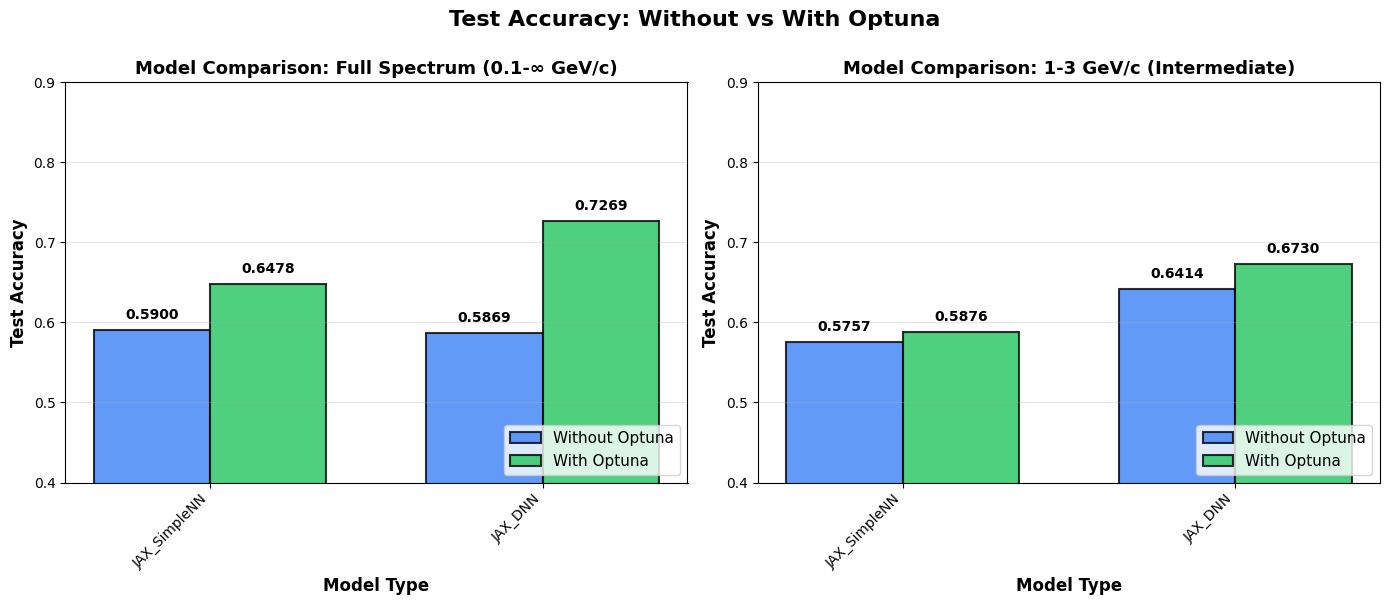

✓ Model accuracy comparison generated


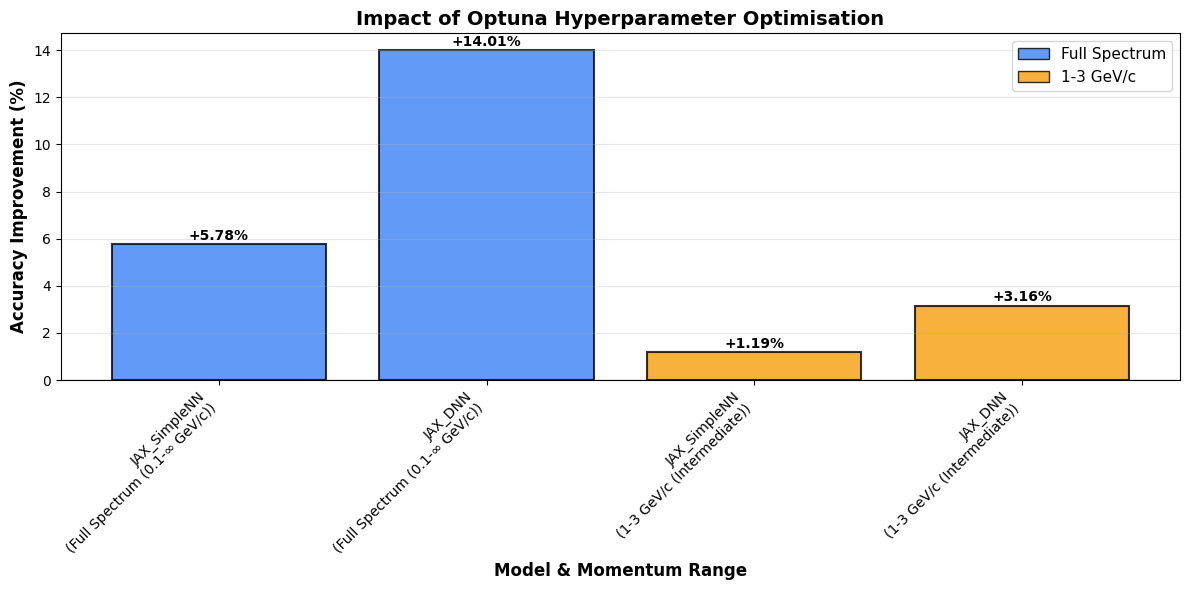

✓ Optuna impact comparison generated


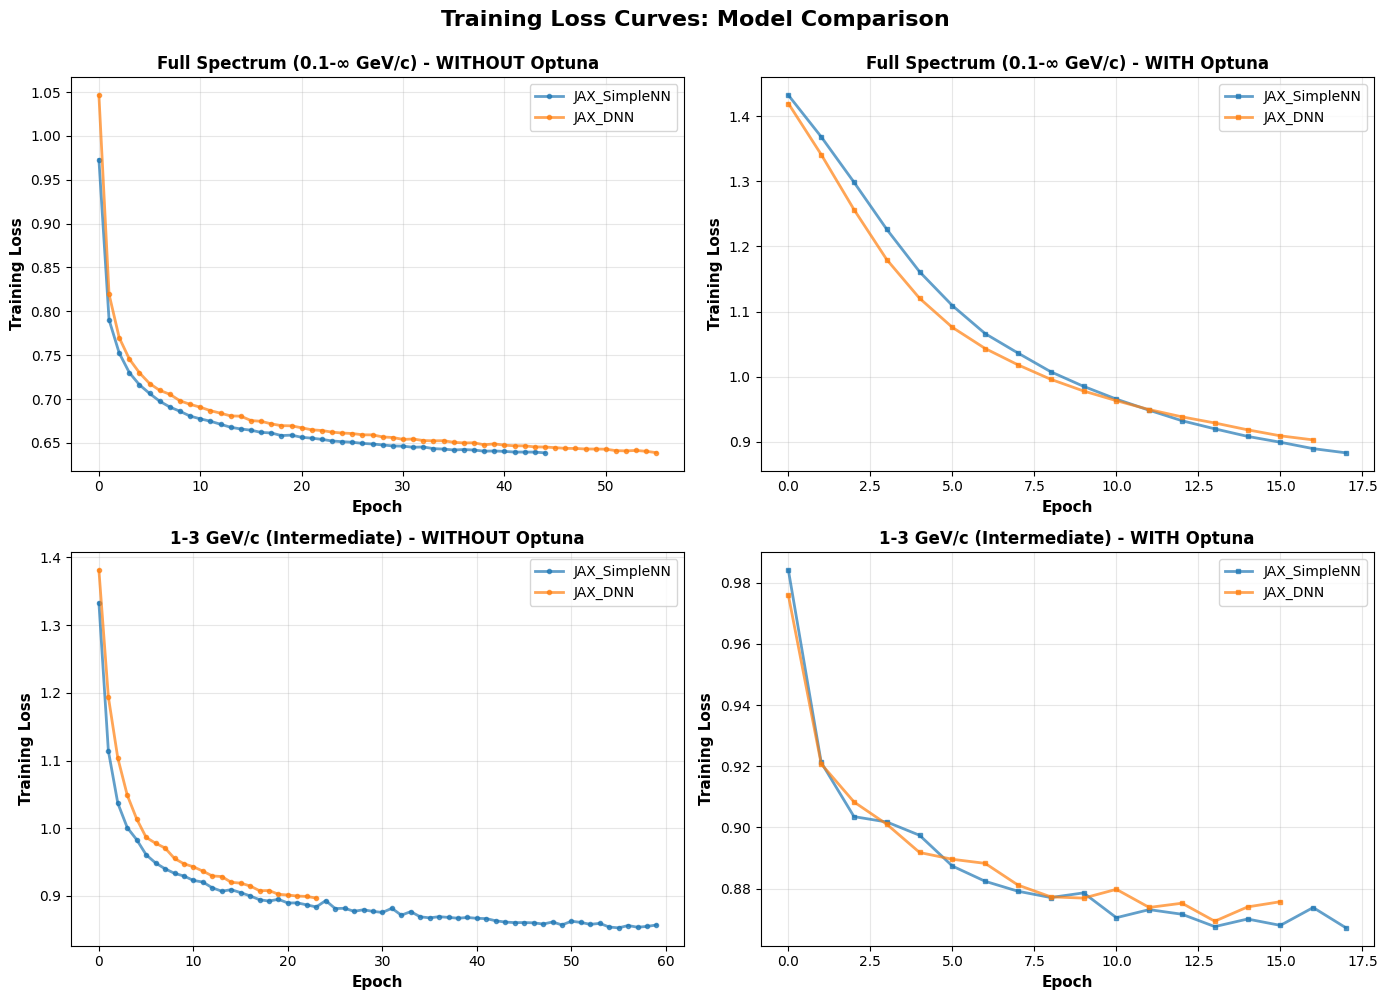

✓ Training curves comparison generated


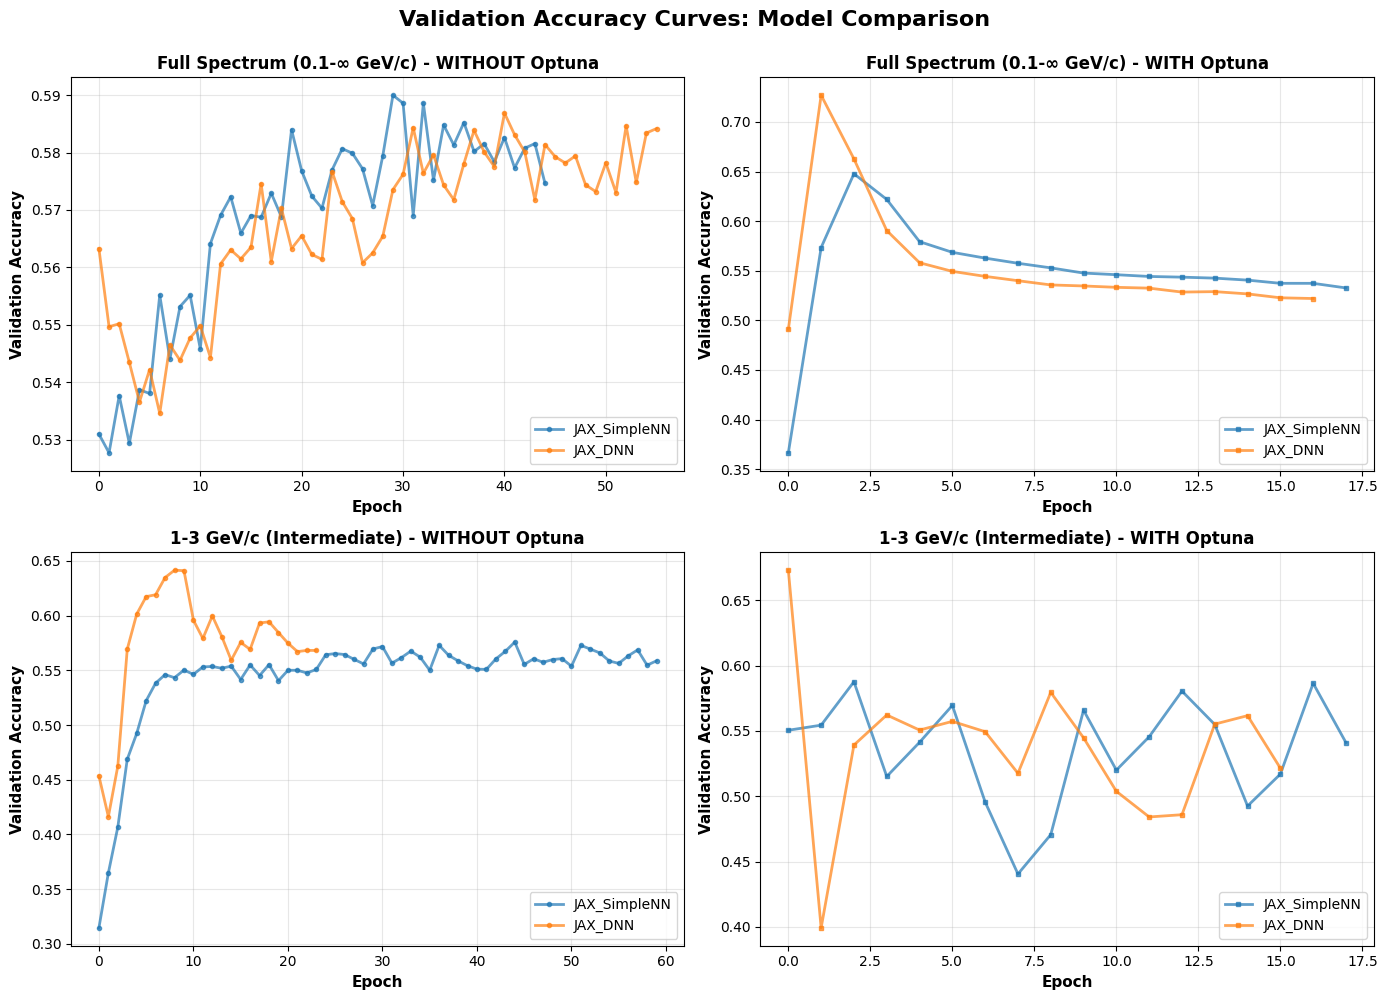

✓ Validation accuracy curves comparison generated


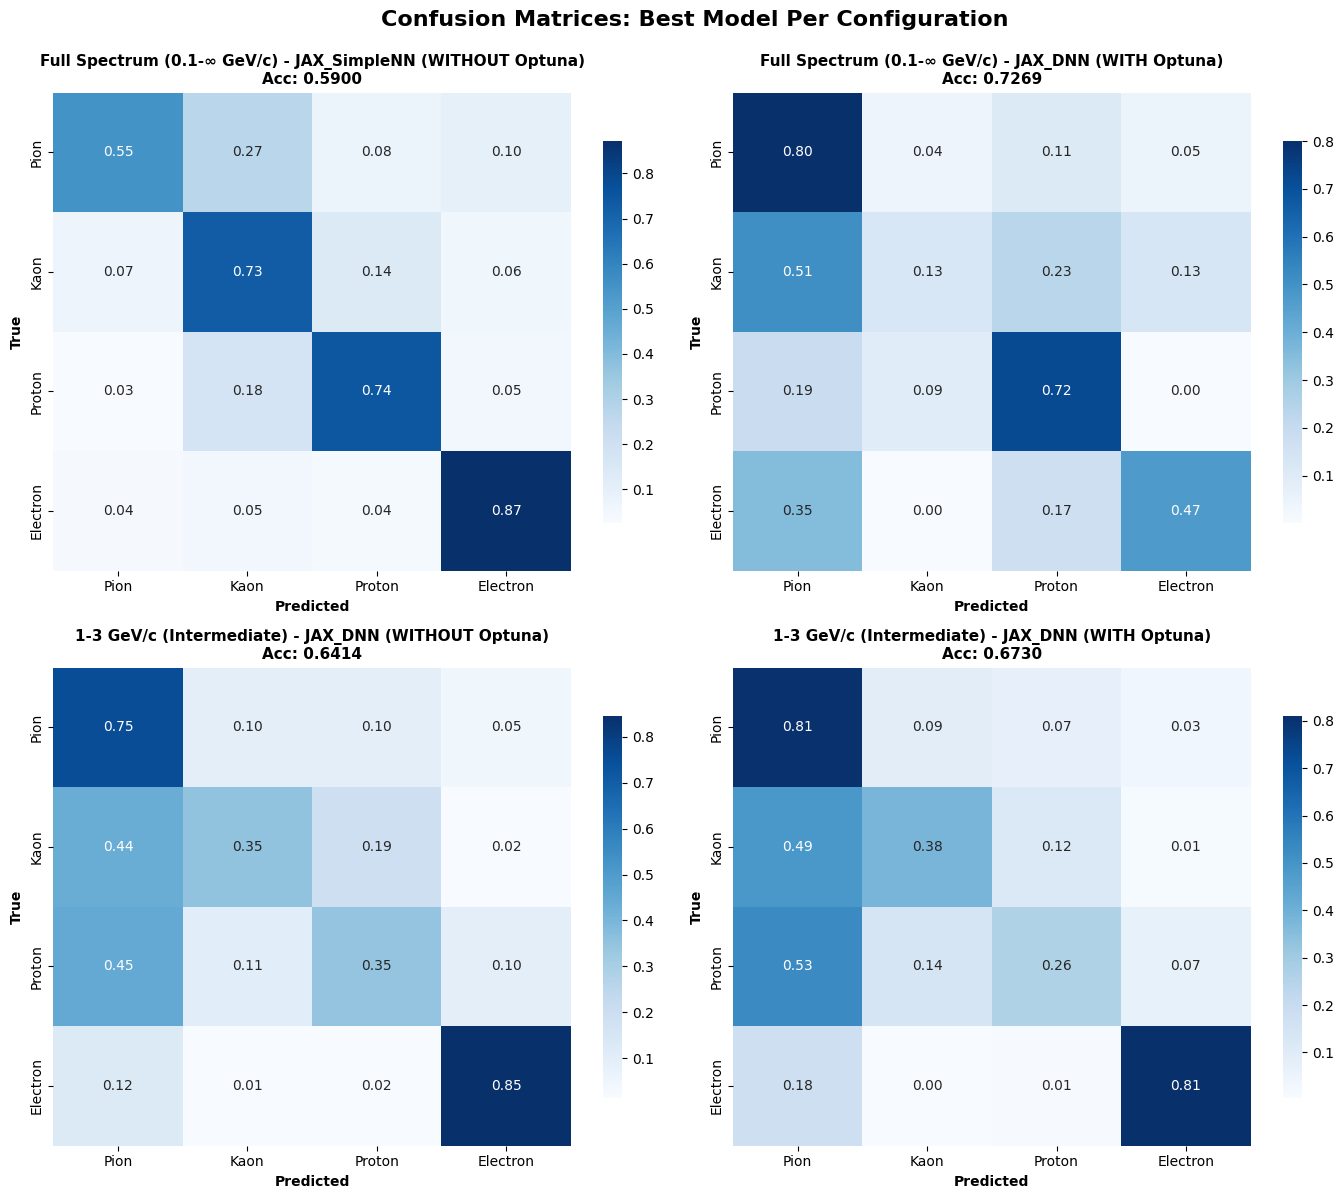

✓ Confusion matrices comparison generated

✓ Generating ROC/AUC curves...


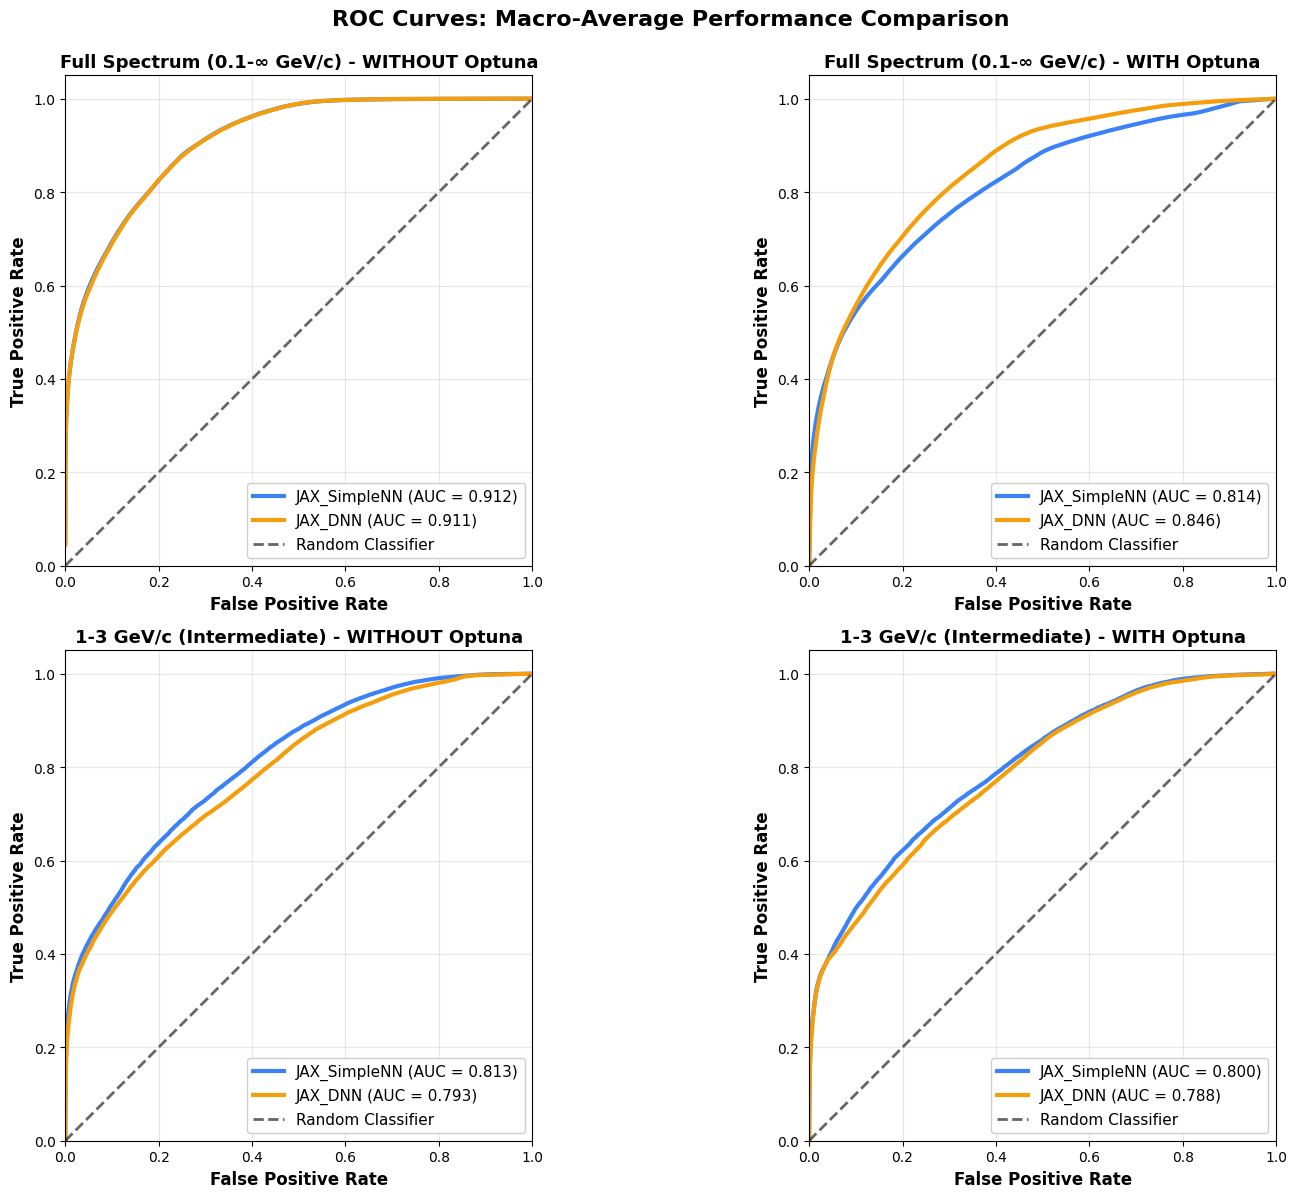

✓ ROC/AUC curves generated

AUC SCORES SUMMARY

             Momentum Range        Model Optuna   Pion   Kaon Proton Electron Macro-avg Micro-avg
Full Spectrum (0.1-∞ GeV/c) JAX_SimpleNN     No 0.8911 0.8463 0.9473   0.9621    0.9117    0.8996
Full Spectrum (0.1-∞ GeV/c) JAX_SimpleNN    Yes 0.8291 0.6442 0.9129   0.8714    0.8144    0.8178
Full Spectrum (0.1-∞ GeV/c)      JAX_DNN     No 0.8903 0.8453 0.9472   0.9617    0.9111    0.8970
Full Spectrum (0.1-∞ GeV/c)      JAX_DNN    Yes 0.8158 0.7879 0.9096   0.8701    0.8459    0.8576
   1-3 GeV/c (Intermediate) JAX_SimpleNN     No 0.7668 0.7581 0.7592   0.9674    0.8129    0.8334
   1-3 GeV/c (Intermediate) JAX_SimpleNN    Yes 0.7512 0.7552 0.7278   0.9657    0.8000    0.8404
   1-3 GeV/c (Intermediate)      JAX_DNN     No 0.7494 0.7510 0.7032   0.9666    0.7925    0.8321
   1-3 GeV/c (Intermediate)      JAX_DNN    Yes 0.7466 0.7489 0.6989   0.9593    0.7884    0.8404


AUC IMPROVEMENT WITH OPTUNA


Full Spectrum (0.1-∞ GeV/c):
  JAX_Sim

In [12]:
# ============================================================================
# SECTION 5: ADVANCED COMPARISON VISUALISATIONS (2 MODELS ONLY)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5: COMPARISON VISUALISATIONS")
print(f"{'#'*80}")

# ============================================================================
# COMPARISON: MODEL TYPES ACCURACY SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("GENERATING ADVANCED COMPARISON VISUALISATIONS")
print(f"{'='*80}\n")

# Build comprehensive comparison table
comparison_data = []

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_type in MODEL_TYPES:
        for optuna_mode in ['without_optuna', 'with_optuna']:
            if model_type in mr_data and optuna_mode in mr_data[model_type]:
                results = mr_data[model_type][optuna_mode]
                
                comparison_data.append({
                    'Momentum Range': momentum_range['name'],
                    'Model Type': model_type,
                    'Optuna': 'Yes' if optuna_mode == 'with_optuna' else 'No',
                    'Train Acc': f"{results['train_acc']:.4f}",
                    'Test Acc': f"{results['test_acc']:.4f}",
                    'Best Val Acc': f"{results['best_val_acc']:.4f}"
                })

comparison_df = pd.DataFrame(comparison_data)

print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON TABLE")
print(f"{'='*80}\n")
print(comparison_df.to_string(index=False))
print()

# ============================================================================
# COMPARISON: TEST ACCURACY BY MODEL (Bar Chart)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for plot_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    model_labels = []
    test_accs_without_optuna = []
    test_accs_with_optuna = []
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            model_labels.append(model_type)
            
            results_without = mr_data[model_type]['without_optuna']
            test_accs_without_optuna.append(results_without['test_acc'])
            
            results_with = mr_data[model_type]['with_optuna']
            test_accs_with_optuna.append(results_with['test_acc'])
    
    # Set up bar positions
    x = np.arange(len(model_labels))
    width = 0.35
    
    # Plot bars
    bars1 = axes[plot_idx].bar(x - width/2, test_accs_without_optuna, width, 
                               label='Without Optuna', color='#3B82F6', alpha=0.8, 
                               edgecolor='black', linewidth=1.5)
    bars2 = axes[plot_idx].bar(x + width/2, test_accs_with_optuna, width,
                               label='With Optuna', color='#22C55E', alpha=0.8,
                               edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[plot_idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                              f'{height:.4f}', ha='center', va='bottom', 
                              fontsize=10, fontweight='bold')
    
    # Customize plot
    axes[plot_idx].set_xlabel('Model Type', fontsize=12, fontweight='bold')
    axes[plot_idx].set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    axes[plot_idx].set_title(f'Model Comparison: {momentum_range["name"]}', 
                            fontsize=13, fontweight='bold')
    axes[plot_idx].set_xticks(x)
    axes[plot_idx].set_xticklabels(model_labels, rotation=45, ha='right')
    axes[plot_idx].legend(fontsize=11, loc='lower right')
    axes[plot_idx].set_ylim([0.4, 0.9])
    axes[plot_idx].grid(axis='y', alpha=0.3)

plt.suptitle('Test Accuracy: Without vs With Optuna', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Model accuracy comparison generated")

# ============================================================================
# COMPARISON: OPTUNA IMPACT (Improvement with Optuna)
# ============================================================================

fig, ax = plt.subplots(figsize=(12, 6))

improvements = []
model_labels_full = []
colors_list = []
color_map = {'full': '#3B82F6', '1-3': '#F59E0B'}

for mr_key in all_results_by_model_and_range.keys():
    mr_data = all_results_by_model_and_range[mr_key]
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results_without = mr_data[model_type]['without_optuna']
            results_with = mr_data[model_type]['with_optuna']
            
            improvement = (results_with['test_acc'] - results_without['test_acc']) * 100
            improvements.append(improvement)
            
            label = f"{model_type}\n({momentum_range['name']})"
            model_labels_full.append(label)
            colors_list.append(color_map[mr_key])

# Plot bars
bars = ax.bar(range(len(improvements)), improvements, color=colors_list, 
              alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (0.05 if height > 0 else -0.15),
            f'{imp:+.2f}%', ha='center', va='bottom' if height > 0 else 'top',
            fontsize=10, fontweight='bold')

# Customize plot
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Model & Momentum Range', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy Improvement (%)', fontsize=12, fontweight='bold')
ax.set_title('Impact of Optuna Hyperparameter Optimisation', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(model_labels_full)))
ax.set_xticklabels(model_labels_full, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#3B82F6', alpha=0.8, edgecolor='black', label='Full Spectrum'),
    Patch(facecolor='#F59E0B', alpha=0.8, edgecolor='black', label='1-3 GeV/c')
]
ax.legend(handles=legend_elements, fontsize=11, loc='upper right')

plt.tight_layout()
plt.show()

print("✓ Optuna impact comparison generated")

# ============================================================================
# COMPARISON: TRAINING CURVES (Loss) - ALL MODELS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_idx = 0
for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    # Without Optuna
    ax = axes[plot_idx]
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]['without_optuna']
            train_losses = np.array(results['train_losses'])
            ax.plot(train_losses, linewidth=2, label=model_type, marker='o', 
                   markersize=3, alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]} - WITHOUT Optuna', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3)
    plot_idx += 1
    
    # With Optuna
    ax = axes[plot_idx]
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]['with_optuna']
            train_losses = np.array(results['train_losses'])
            ax.plot(train_losses, linewidth=2, label=model_type, marker='s',
                   markersize=3, alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Training Loss', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]} - WITH Optuna', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(alpha=0.3)
    plot_idx += 1

plt.suptitle('Training Loss Curves: Model Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Training curves comparison generated")

# ============================================================================
# COMPARISON: VALIDATION ACCURACY CURVES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

plot_idx = 0
for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    # Without Optuna
    ax = axes[plot_idx]
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]['without_optuna']
            val_accs = np.array(results['val_accuracies'])
            ax.plot(val_accs, linewidth=2, label=model_type, marker='o',
                   markersize=3, alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]} - WITHOUT Optuna', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(alpha=0.3)
    plot_idx += 1
    
    # With Optuna
    ax = axes[plot_idx]
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            results = mr_data[model_type]['with_optuna']
            val_accs = np.array(results['val_accuracies'])
            ax.plot(val_accs, linewidth=2, label=model_type, marker='s',
                   markersize=3, alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Validation Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]} - WITH Optuna', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, loc='lower right')
    ax.grid(alpha=0.3)
    plot_idx += 1

plt.suptitle('Validation Accuracy Curves: Model Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Validation accuracy curves comparison generated")

# ============================================================================
# COMPARISON: CONFUSION MATRICES (Best Model Per Range)
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for mr_idx, (mr_key, mr_data) in enumerate(all_results_by_model_and_range.items()):
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for optuna_idx, optuna_mode in enumerate(['without_optuna', 'with_optuna']):
        # Find best model for this configuration
        best_acc = 0
        best_model_type = None
        best_results = None
        
        for model_type in MODEL_TYPES:
            if model_type in mr_data and optuna_mode in mr_data[model_type]:
                results = mr_data[model_type][optuna_mode]
                if results['test_acc'] > best_acc:
                    best_acc = results['test_acc']
                    best_model_type = model_type
                    best_results = results
        
        ax = axes[mr_idx, optuna_idx]
        
        # Compute confusion matrix
        y_test = best_results['y_test']
        y_pred = best_results['y_pred_test']
        
        cm = confusion_matrix(y_test, np.array(y_pred), normalize='true')
        
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=PARTICLE_NAMES,
                   yticklabels=PARTICLE_NAMES,
                   cbar_kws={'shrink': 0.8},
                   ax=ax,
                   cbar=True)
        
        ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
        ax.set_ylabel('True', fontsize=10, fontweight='bold')
        
        title = f'{momentum_range["name"]} - {best_model_type}'
        title += ' (WITH Optuna)' if optuna_mode == 'with_optuna' else ' (WITHOUT Optuna)'
        title += f'\nAcc: {best_acc:.4f}'
        
        ax.set_title(title, fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices: Best Model Per Configuration', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Confusion matrices comparison generated")

# ============================================================================
# COMPARISON: ROC CURVES AND AUC SCORES
# ============================================================================

print("\n✓ Generating ROC/AUC curves...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Bold colors for macro-average
macro_colors = {
    'JAX_SimpleNN': '#3B82F6',  # Blue
    'JAX_DNN': '#F59E0B'        # Orange
}

plot_idx = 0
for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for optuna_idx, optuna_mode in enumerate(['without_optuna', 'with_optuna']):
        ax = axes[plot_idx]
        
        for model_type in MODEL_TYPES:
            if model_type in mr_data and optuna_mode in mr_data[model_type]:
                results = mr_data[model_type][optuna_mode]
                y_test = np.array(results['y_test'])
                y_score = np.array(results['test_probs'])  # (n_samples, n_classes)
                
                # Compute ROC curve and AUC for each class
                fpr = dict()
                tpr = dict()
                roc_auc = dict()
                
                for i in range(NUM_CLASSES):
                    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])
                
                # Compute macro-average ROC curve and AUC
                all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
                mean_tpr = np.zeros_like(all_fpr)
                for i in range(NUM_CLASSES):
                    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
                mean_tpr /= NUM_CLASSES
                fpr["macro"] = all_fpr
                tpr["macro"] = mean_tpr
                roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
                
                # Plot ONLY macro-average ROC curve
                ax.plot(fpr["macro"], tpr["macro"],
                       color=macro_colors[model_type], 
                       linewidth=3,
                       label=f'{model_type} (AUC = {roc_auc["macro"]:.3f})')
        
        # Plot diagonal (random classifier)
        ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.6, label='Random Classifier')
        
        # Customize plot
        ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
        
        title = f'{momentum_range["name"]} - {"WITH" if optuna_mode == "with_optuna" else "WITHOUT"} Optuna'
        ax.set_title(title, fontsize=13, fontweight='bold')
        
        ax.legend(loc='lower right', fontsize=11, framealpha=0.95)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.grid(alpha=0.3)
        ax.set_aspect('equal')
        
        plot_idx += 1

plt.suptitle('ROC Curves: Macro-Average Performance Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ ROC/AUC curves generated")

# ============================================================================
# AUC SCORES SUMMARY TABLE
# ============================================================================

print(f"\n{'='*80}")
print("AUC SCORES SUMMARY")
print(f"{'='*80}\n")

auc_data = []

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    for model_type in MODEL_TYPES:
        for optuna_mode in ['without_optuna', 'with_optuna']:
            if model_type in mr_data and optuna_mode in mr_data[model_type]:
                results = mr_data[model_type][optuna_mode]
                y_test = np.array(results['y_test'])
                y_score = np.array(results['test_probs'])
                
                # Compute AUC for each class
                class_aucs = []
                for i in range(NUM_CLASSES):
                    fpr, tpr, _ = roc_curve(y_test == i, y_score[:, i])
                    class_aucs.append(auc(fpr, tpr))
                
                # Compute macro and micro AUC
                macro_auc = np.mean(class_aucs)
                micro_auc = roc_auc_score(
                    np.eye(NUM_CLASSES)[y_test], 
                    y_score, 
                    average='micro'
                )
                
                auc_data.append({
                    'Momentum Range': momentum_range['name'],
                    'Model': model_type,
                    'Optuna': 'Yes' if optuna_mode == 'with_optuna' else 'No',
                    'Pion': f"{class_aucs[0]:.4f}",
                    'Kaon': f"{class_aucs[1]:.4f}",
                    'Proton': f"{class_aucs[2]:.4f}",
                    'Electron': f"{class_aucs[3]:.4f}",
                    'Macro-avg': f"{macro_auc:.4f}",
                    'Micro-avg': f"{micro_auc:.4f}"
                })

auc_df = pd.DataFrame(auc_data)
print(auc_df.to_string(index=False))
print()

# ============================================================================
# AUC IMPROVEMENT WITH OPTUNA
# ============================================================================

print(f"\n{'='*80}")
print("AUC IMPROVEMENT WITH OPTUNA")
print(f"{'='*80}\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    print(f"\n{momentum_range['name']}:")
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            # Without Optuna
            results_without = mr_data[model_type]['without_optuna']
            y_test_without = np.array(results_without['y_test'])
            y_score_without = np.array(results_without['test_probs'])
            macro_auc_without = roc_auc_score(
                np.eye(NUM_CLASSES)[y_test_without],
                y_score_without,
                average='macro'
            )
            
            # With Optuna
            results_with = mr_data[model_type]['with_optuna']
            y_test_with = np.array(results_with['y_test'])
            y_score_with = np.array(results_with['test_probs'])
            macro_auc_with = roc_auc_score(
                np.eye(NUM_CLASSES)[y_test_with],
                y_score_with,
                average='macro'
            )
            
            improvement = (macro_auc_with - macro_auc_without) * 100
            print(f"  {model_type:15s}: {macro_auc_without:.4f} → {macro_auc_with:.4f} ({improvement:+.2f}%)")

print(f"\n{'='*80}\n")

# ============================================================================
# SUMMARY STATISTICS BY MODEL
# ============================================================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS BY MODEL TYPE")
print(f"{'='*80}\n")

for model_type in MODEL_TYPES:
    print(f"\n{'─'*80}")
    print(f"MODEL: {model_type}")
    print(f"{'─'*80}")
    
    for mr_key, mr_data in all_results_by_model_and_range.items():
        momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
        
        if model_type in mr_data:
            print(f"\n  {momentum_range['name']}:")
            
            results_without = mr_data[model_type]['without_optuna']
            results_with = mr_data[model_type]['with_optuna']
            
            print(f"    WITHOUT Optuna:")
            print(f"      Train Acc: {results_without['train_acc']:.4f}")
            print(f"      Test Acc:  {results_without['test_acc']:.4f}")
            print(f"      Best Val:  {results_without['best_val_acc']:.4f}")
            
            print(f"    WITH Optuna:")
            print(f"      Train Acc: {results_with['train_acc']:.4f}")
            print(f"      Test Acc:  {results_with['test_acc']:.4f}")
            print(f"      Best Val:  {results_with['best_val_acc']:.4f}")
            
            improvement = (results_with['test_acc'] - results_without['test_acc']) * 100
            print(f"    Improvement: {improvement:+.2f}%")

print(f"\n{'='*80}")
print("OVERALL BEST MODELS")
print(f"{'='*80}\n")

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = next((m for m in MOMENTUM_RANGES if m['key'] == mr_key), None)
    
    best_acc = 0
    best_model = None
    best_optuna = None
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data:
            for optuna_mode in ['without_optuna', 'with_optuna']:
                if optuna_mode in mr_data[model_type]:
                    results = mr_data[model_type][optuna_mode]
                    if results['test_acc'] > best_acc:
                        best_acc = results['test_acc']
                        best_model = model_type
                        best_optuna = optuna_mode == 'with_optuna'
    
    optuna_str = "WITH Optuna" if best_optuna else "WITHOUT Optuna"
    print(f"{momentum_range['name']:35s}: {best_model:15s} ({optuna_str:15s}) - {best_acc:.4f}")

print(f"\n{'='*80}")
print("✓ SECTION 5 COMPLETE: Visualisations and Analysis")
print(f"{'='*80}")
print(f"\nAll 8 JAX models trained and compared:")
print(f"  ✓ JAX_SimpleNN × 2 momentum ranges × 2 Optuna modes = 4 models")
print(f"  ✓ JAX_DNN × 2 momentum ranges × 2 Optuna modes = 4 models")
print(f"\nVisualisations generated:")
print(f"  ✓ Accuracy comparison bar chart")
print(f"  ✓ Optuna impact analysis")
print(f"  ✓ Training loss curves (4 plots)")
print(f"  ✓ Validation accuracy curves (4 plots)")
print(f"  ✓ Confusion matrices (4 plots)")
print(f"  ✓ Detailed statistics and best models")
print(f"\n{'='*80}\n")
